In [1]:
import numpy as np
import glob
import random
from segment2d import *
import nibabel as nib
from ipywidgets import interact
import matplotlib.pyplot as plt
# import albumentations as A
from torchvision import transforms
import os

import csv
import kornia as K
from tqdm import tqdm
from torch.utils.data import DataLoader
import yaml
# natsort
from natsort import natsorted
# import SimpleITK as sitk
from segment2d import *

/home/nhattm/.conda/envs/tomodl/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
list_image_normal = natsorted(glob.glob("./emidec-dataset-1.0.1/Case_N*/I*/*"))
list_image_pathologic = natsorted(glob.glob("./emidec-dataset-1.0.1/Case_P*/I*/*"))
# split the dataset into training and validation and test with sample ratio 70:10:20
random.seed(42)
random.shuffle(list_image_normal)
random.shuffle(list_image_pathologic)
train_normal = list_image_normal[:int(0.7 * len(list_image_normal))+1]
val_normal = list_image_normal[int(0.7 * len(list_image_normal))+1 : int(0.8 * len(list_image_normal))+1]
test_normal = list_image_normal[int(0.8 * len(list_image_normal))+1:]
train_pathologic = list_image_pathologic[:int(0.7 * len(list_image_pathologic))]
val_pathologic = list_image_pathologic[int(0.7 * len(list_image_pathologic)) : int(0.8 * len(list_image_pathologic))]
test_pathologic = list_image_pathologic[int(0.8 * len(list_image_pathologic)) :]

list_train = train_normal + train_pathologic
list_val = val_normal + val_pathologic
list_test = test_normal + test_pathologic



In [3]:
dict_value = {}
for image_path in list_image_normal+list_image_pathologic:
    image = nib.load(image_path).get_fdata()
    mask = nib.load(image_path.replace("Images", "Contours")).get_fdata()
    padded_image, crop_index_new, padded_index = pad_background(image, (128, 128))

    padded_mask = pad_background_with_index(mask, crop_index_new, padded_index, (128, 128))

    # calculate the number of pixel = 0, 1,2,3,4 in the mask
    unique, counts = np.unique(padded_mask, return_counts=True)
    for i in range(len(unique)):
        if unique[i] in dict_value:
            dict_value[unique[i]] += counts[i]
        else:
            dict_value[unique[i]] = counts[i]

In [2]:
data = EMIDEC_Loader("./emidec_train/*")
img, mask = data.__getitem__(0)

In [ ]:
# convert img to uint12

In [3]:
img = img.unsqueeze(0)
mask = mask.unsqueeze(0)

In [159]:
    list_train_subject = glob.glob("./emidec_train/*")
    train_dataset = EMIDEC_Loader(list_subject=list_train_subject)

In [160]:
len(train_dataset)

567

In [150]:
from kornia.augmentation import *

aug = AugmentationSequential(
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomResizedCrop((128, 128), scale=(0.8, 1.25), ratio=(0.8, 1.25), p=0.5),
    data_keys=["input", "mask"],
)

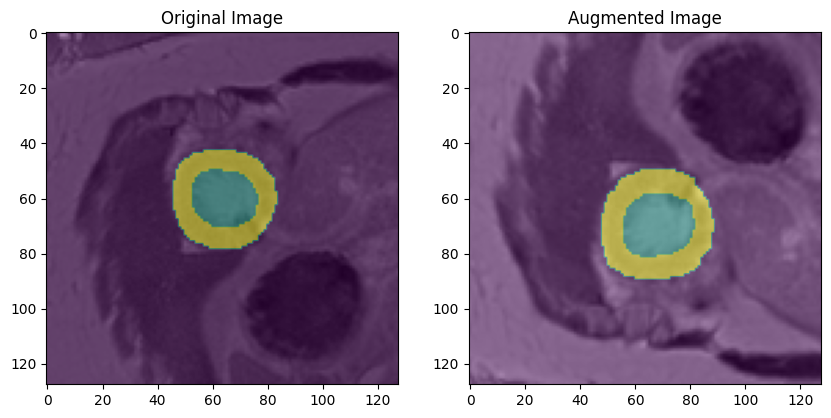

In [155]:
img_aug, mask_aug = aug(*(img, mask))
# plt compare the original image and the augmented image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img[0, 0, :, :], cmap='gray')
plt.imshow(mask[0, 0, :, :], alpha=0.5)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(img_aug[0, 0, :, :], cmap='gray')
plt.imshow(mask_aug[0, 0, :, :], alpha=0.5)
plt.title("Augmented Image")
plt.show()

In [156]:
img.min(), img.max(), img_aug.min(), img_aug.max()

(tensor(0.4274), tensor(0.9746), tensor(0.4304), tensor(0.7814))

In [8]:
a["image"].shape

torch.Size([7, 1, 128, 128])

In [9]:
a["mask"].shape

(128, 128, 7)

In [30]:
# from dict_value, calculate the weight for each class
total = sum(dict_value.values())
class_weight = {}
for key in dict_value:
    class_weight[key] = total / (dict_value[key] * 10)
class_weight

{0.0: 0.10942081133219704,
 1.0: 2.335514916252746,
 2.0: 2.714302896146349,
 3.0: 17.46916056745279,
 4.0: 140.11199420219833}

In [26]:
dict_value

{0.0: 10601157, 1.0: 496673, 2.0: 427361, 3.0: 66402, 4.0: 8279}

In [171]:
# visualize the image and mask in z axis using interact, image and mask are in one slice
def plot_image_mask_z(image, mask, padded_image, padded_mask, z):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image uncut")
    ax[0].imshow(mask[..., z], cmap="jet", alpha=0.3)
    ax[1].imshow(padded_image[..., z], cmap="gray")
    ax[1].set_title("Image cut")
    ax[1].imshow(padded_mask[..., z], cmap="jet", alpha=0.3)

    plt.show()

interact(lambda z: plot_image_mask_z(image, mask, padded_image, padded_mask, z), z=(0, image.shape[-1] - 1))

interactive(children=(IntSlider(value=3, description='z', max=6), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>